In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mrexo.predict_nd import Mdwarf_InferPlMass_FromPlRadiusStMass, Mdwarf_InferPlMass_FromPlRadius
import scipy.integrate as spi
import copy

In [3]:
n_s = 1 # number of systems simulated
p_l, p_h = 0, 2 # high and low limits for log-scale periods (to draw from uniform distribution)
k = 1 # proportional coefficient for Kepler's third law, a^3 = kp^2

f_swpa_med = 0.88
m = 0.9
lambda_c = 1 
lambda_p = 1.6 # expected number of planets around a star
delta_c = 10
alpha_p = 0
alpha_r1 = -1.4
alpha_r2 = -5.2
alpha_e1 = 0.25
sigma_r = 0.3
sigma_p = 0.25
sigma_e1 = 0.25
n_cmax = 3#??
n_pmax = 3#??
r_p_break = 3 # in Earth radii units
r_p_min = 0.5 # Earth radii
r_p_max = 10 # Earth radii
r_p_c = 3 # Earth radii
p_min = 3 # days
p_max = 300 # days

In [4]:
def ztp(l):
    x = 0
    while x == 0:
        x = np.random.poisson(l)
    return x

def radii():
    inc = 3000
    x = np.linspace(r_p_min, r_p_max, inc)
    y = np.zeros((inc, 2))
    rpc1 = lambda x: x ** alpha_r1 # broken power functions
    rpc2 = lambda x: r_p_break ** (alpha_r1 - alpha_r2) * x ** alpha_r2 # constant used to stitch together the two regimes
    for i in range(len(x)):
        if x[i] <= r_p_break:
            y[i] = [x[i], spi.quad(rpc1, r_p_min, x[i])[0]] 
        else:
            y[i] = [x[i], spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, x[i])[0]]
    normalization = spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, r_p_max)[0] # sum of entire area under curve
    i = np.random.uniform(0, 1)
    id = (np.abs(y[:,1]/normalization - i)).argmin() # index of closest point
    return y[id, 0]

def period_scale(): # period scale factor
    inc = 3000
    x = np.linspace(p_min, p_max, inc)
    y = np.zeros((inc, 2))
    pc = lambda x: x ** alpha_p # broken power functions
    for i in range(len(x)):
        y[i] = [x[i], spi.quad(pc, p_min, x[i])[0]] 
    normalization = spi.quad(pc, p_min, p_max)[0] # sum of entire area under curve
    i = np.random.uniform(0, 1)
    id = (np.abs(y[:,1]/normalization - i)).argmin() # index of closest point
    return y[id, 0]

In [6]:
# Step numbers correspond to section 2.3.4 New Procedure in the paper

# Our data will be set up as the following: Each table represents data for one simulated system
# [0]: stellar radius (solar rad) INPUT
# [1]: stellar mass (solar mass) INPUT
# [2]: total AMD
# [3]: number of clusters = n_c
# [4]: number of planets = n_p1 in the first cluster
# [5]: period scale factor
#
# Now looping over each value of n_p1:
# [6+13*n_p1+0]: each planet's radius
# [6+13*n_p1+1]: each planet's mass
# [6+13*n_p1+2]: each planet's unscaled period
# [6+13*n_p1+3]: each planet's scaled period
# [6+13*n_p1+4]: each planet's AMD in x
# [6+13*n_p1+5]: each planet's AMD in y
# [6+13*n_p1+6]: each planet's AMD in z
# [6+13*n_p1+7]: each planet's eccentricity
# [6+13*n_p1+8]: each planet's omega
# [6+13*n_p1+9]: each planet's mutial inclination rel. to system invar. plane
# [6+13*n_p1+10]: each planet's angle of ascending node
# [6+13*n_p1+11]: each planet's mean anomaly
# [6+13*n_p1+12]: each planet's inclination 
#
# [6+13*n_p1]: number of planets = n_p2 in second cluster
# [7+13*n_p1]: period scale factor
# [8+13*n_p1+13*n_p2+0] etc
# empty array needs to be size 4 + 2*n_c + 13*(sum n_p)


# generate number of clusters
clusters = np.random.poisson(lambda_c, n_s)
for i in range(n_s):
    if clusters[i] == 0:
        clusters[i] = ztp(lambda_c) # zero truncated poisson
total_clusters = np.sum(clusters)

# generate number of planets for each cluster
nums = np.random.poisson(lambda_p, total_clusters)
for i in range(total_clusters):
    if nums[i] == 0:
        nums[i] = ztp(lambda_p)

# calculating space that need to be allocated, each row starts with num of clusters and lists num of planets in each cluster
calc_num_rows = np.zeros((n_s, np.max(clusters)+1))
for i in range(n_s):
    counter = 0
    calc_num_rows[i][0] = clusters[i]
    for j in range(clusters[i]):
        calc_num_rows[i][j+1] = nums[counter]
        counter += 1
calc_num = np.zeros(n_s)
for i in range(n_s):
    calc_num[i] = 4 + 2 * calc_num_rows[i][0] + 13 * np.sum(calc_num_rows[i][1:])

data = np.zeros((n_s, int(np.max(calc_num))))
print(nums) #number of planet in each cluster

[1 3]


In [8]:
for row in range(n_s):
    # Step 1: USER INPUT!
    data[row][0] = 1 #input('Enter stellar radius (in solar radii): ')
    data[row][1] = 1 #input('Enter stellar mass (in solar mass): ')
    
    c = 0
    while c < 0.5 or c > 1.7:
        c = np.random.rayleigh(0.81)
    
    # Step 2:
    f_swpa = max(0, min(m*(c-0.81)+f_swpa_med, 1))
    if np.random.uniform(0, 1) > f_swpa:
        data[row][1] = 0 # no planets
        continue
    
    # Step 3: # number of clusters
    data[row][3] = clusters[row]
    print(data[row][3])
    cluster_counter = 0
    
    all_scaled_periods = [] #this will be a 2D array, where each entry is for one planet, in the form of [period, mass]
    
    while cluster_counter < data[row][3]:
        (print(f'currently on cluster: {cluster_counter}'))
        # Step 4(a):
        planets_thus_far = int(sum(calc_num_rows[row][1:cluster_counter+1]))
        planets_in_this_c = 4+2*cluster_counter+13*planets_thus_far
        data[row][planets_in_this_c] = calc_num_rows[row][cluster_counter+1] # number of exoplanets in the cluster
        print(f'number of exoplanets: {data[row][planets_in_this_c]}')
        # Step 4(b):
        r_p_c = radii()
        while r_p_c < 0.5662:
            r_p_c = radii()
        print(f'rpc = {r_p_c}')
        if data[row][planets_in_this_c] == 1:
            data[row][planets_in_this_c+2] = r_p_c
        else:
            for i in range(int(data[row][planets_in_this_c])):
                data[row][planets_in_this_c+2+13*i] = np.exp(np.random.normal(np.log(r_p_c), sigma_r))
                while data[row][planets_in_this_c+2+13*i] < 0.5662 or data[row][planets_in_this_c+2+13*i] > 14.4:
                    data[row][planets_in_this_c+2+13*i] = np.exp(np.random.normal(np.log(r_p_c), sigma_r)) 
                print(f'radius: {data[row][planets_in_this_c+2+13*i]}')
        # Step 4(c):
        for j in range(int(data[row][planets_in_this_c])):
            if data[row][0]<0.072 or data[row][0]> 0.726: # if out of bounds for 3D fitting
                data[row][planets_in_this_c+3+13*j] = Mdwarf_InferPlMass_FromPlRadius(pl_rade = data[row][planets_in_this_c+2+13*j])[0]
                print(f'mass: {data[row][planets_in_this_c+3+13*j]}')
            else:
                data[row][planets_in_this_c+3+13*j] = Mdwarf_InferPlMass_FromPlRadiusStMass(pl_rade=data[row][planets_in_this_c+2+13*j], st_mass=[data[row][0]])[0][0]
                print(f'mass: {data[row][planets_in_this_c+3+13*j]}')
        # Step 4(d)
        if data[row][planets_in_this_c] == 1:
            data[row][planets_in_this_c+4] = 1 #unscaled period
            periods = np.array([1])
        else: 
            s = 0 # drawing unscaled periods
            while s < 100:
                stability = True
                periods = np.random.lognormal(0, data[row][planets_in_this_c]*sigma_p, int(data[row][planets_in_this_c]))
                periods = np.sort(periods)
                #print(s)
                print(periods)
                for i in range(len(periods)-1):
                    r_h = 0.5 * (periods[i]+periods[i+1]) * ((data[row][planets_in_this_c+3+13*i] + data[row][planets_in_this_c+3+13*(i+1)])/(3*333000*data[row][1])) ** (1/3)
                    stab_cond = (periods[i+1] - periods[i])/r_h
                    if stab_cond <= 8: # stability criterion
                        #print(f'stab cond = {stab_cond}')
                        #print('stab not met')
                        stability = False
                        s += 1
                        break
                    mu_1 = data[row][planets_in_this_c+3+13*i] / (333000*data[row][1]) #planet star mass ratio
                    mu_2 = data[row][planets_in_this_c+3+13*(i+1)] / (333000*data[row][1])
                    alpha_crit = 1 - 1.46 * (mu_1 + mu_2) ** (2 / 7)
                    alpha = (periods[i]/periods[i+1]) ** (2/3) # semimajor axis ratio (from period conversion)
                    #print(f'alpha = {alpha}')
                    #print(f'alpha_crit = {alpha_crit}')
                    if alpha > alpha_crit: # against mean motion resonance overlap
                        #print('stab not met')
                        stability = False
                        s += 1
                        break
                if stability:
                    for i in range(int(data[row][planets_in_this_c])):
                        data[row][planets_in_this_c+4+13*i] = periods[i] #input unscaled periods
                    #print('stab met')
                    break
            if s == 100: 
                continue
        # Step 4(e) scaling periods (days)
        q = 0
        while q < 100:
            print('scaling')
            print(f'unscaled periods: {periods}')
            p_c = period_scale()
            data[row][5+2*cluster_counter+13*planets_thus_far] = p_c
            scaled_periods = p_c * periods
            print(f'p_c: {p_c}')
            print(f'scaled periods: {scaled_periods}')
            while scaled_periods[0] < p_min or scaled_periods[-1] > p_max:
                print(f'scaled periods out of bounds')
                p_c = period_scale()
                data[row][5+2*cluster_counter+12*planets_thus_far] = p_c
                scaled_periods = p_c * periods
                print(p_c)
                print(f'scaled periods: {scaled_periods}')
            test_scaled_periods = copy.deepcopy(all_scaled_periods)
            for i in range(len(scaled_periods)):
                test_scaled_periods.append([scaled_periods[i], data[row][planets_in_this_c+3+13*i]])
            test_scaled_periods.sort(key=lambda x: x[0])
            print(f'test scale periods are: {test_scaled_periods}')
            stability = True
            for i in range(len(test_scaled_periods)-1):
                r_h = 0.5 * (test_scaled_periods[i][0]+test_scaled_periods[i+1][0]) * ((test_scaled_periods[i][1] + test_scaled_periods[i+1][1])/(3*333000*data[row][1])) ** (1/3)
                stab_cond = (test_scaled_periods[i+1][0] - test_scaled_periods[i][0])/r_h
                if stab_cond <= 8: # stability criterion
                    #print(f'stab cond = {stab_cond}')
                    #print('stab not met')
                    stability = False
                    s += 1
                    break
                mu_1 = test_scaled_periods[i][1] / (333000*data[row][1]) #planet star mass ratio
                mu_2 = test_scaled_periods[i+1][1] / (333000*data[row][1])
                alpha_crit = 1 - 1.46 * (mu_1 + mu_2) ** (2 / 7)
                alpha = (test_scaled_periods[i][0]/test_scaled_periods[i+1][0]) ** (2/3) # semimajor axis ratio (from period conversion)
                #print(f'alpha = {alpha}')
                #print(f'alpha_crit = {alpha_crit}')
                if alpha > alpha_crit: # against mean motion resonance overlap
                    print('stab not met')
                    stability = False
                    s += 1
                    break
            if stability:
                for i in range(int(data[row][planets_in_this_c])):
                    data[row][planets_in_this_c+5+13*i] = scaled_periods[i]
                all_scaled_periods = copy.deepcopy(test_scaled_periods)
                print('stab met')
                break
        if q == 100: 
            continue
        cluster_counter += 1
    
    #Step 5
    if data[row][3] == 1 and data[row][4] == 1:
        data[row][13] = np.random.rayleigh(sigma_e1) #eccentricity
        data[row][14] = np.random.uniform(0, 2*np.pi) #pericenter
    else:
        print('.')
        

2.0
currently on cluster: 0
number of exoplanets: 1.0
rpc = 1.3806268756252082
mass: 2.4806324544582545
scaling
unscaled periods: [1]
p_c: 94.50650216738913
scaled periods: [94.50650217]
test scale periods are: [[94.50650216738913, 2.4806324544582545]]
stab met
currently on cluster: 1
number of exoplanets: 3.0
rpc = 0.731243747915972
radius: 0.6716698045673549
radius: 0.7358355916865452
radius: 0.6986266504114997
mass: 0.351541888299774
mass: 0.42069812387389394
mass: 0.38517651363067473
[0.65074942 0.78412744 1.29268161]
scaling
unscaled periods: [0.65074942 0.78412744 1.29268161]
p_c: 195.61920640213404
scaled periods: [127.29908545 153.39038665 252.87335141]
test scale periods are: [[94.50650216738913, 2.4806324544582545], [127.29908545400419, 0.351541888299774], [153.39038664852686, 0.42069812387389394], [252.8733514130163, 0.38517651363067473]]
stab met
.


In [ ]:
# pseudo code for calculating AMD

AMD_crit_array = np.zeros(len(listOfPlanets))

def computeGamma(mp, ms, period):
    return = mp * earthSunMassRatio / ms * np.sqrt(k * period ** (2/3))

AMD_crit_array[0] = computeGamma(m_1, ms, period)

for x in listOfPlanets(2, N): 
    gamma = mass of inner planet x-1 / mass of outer planet x
    alpha = (period of inner / period of outer) ** (2/3)
    
    e_1 = solve(alpha*(e_1 + 1) + (gamma * e_1) / (np.sqrt(alpha*(1-e_1^2) + gamma ** 2 * e_1 ** 2)) - 1# = 0)
    e_2 = 1 - alpha - alpha * e_1
    
    #critical relative AMD for collision
    C_coll = gamma * np.sqrt(alpha) * (1-np.sqrt(1-e_1**2)) + (1-np.sqrt(1-e_2**2))
    
    r = 0.80199
    epsilon = (mass_1 + mass_2) / stellar mass 
    g = (81 * (1 - alpha) ** 5) / (2**9 * r * epsilon) - (32 * r * epsilon) / (9 * (1 - alpha) ** 2)
    
    #critical relative AMD for MMR
    C_MMR = (g ** 2 * gamma * np.sqrt(alpha)) / (2 + 2 * gamma * np.sqrt(alpha))
    
    AMD_crit_array[x-1] = computeGamma(m_2, ms, period2) * min(C_coll, C_MMR)

AMD_crit = min(AMD_crit_array)

planet_mass_sum = 0

for x in planet:
    planet_mass_sum += x.mass

for x in planet:
    AMD_x = x.mass / planet_mass_sum * AMD_crit

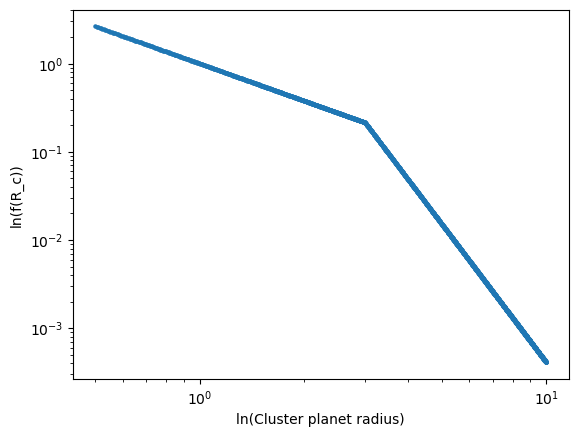

In [9]:
# this cell + below are just for testing functions for picking values
# graphical demonstration of broken power law code for radii

inc = 2000
x = np.linspace(r_p_min, r_p_max, inc)
y = np.zeros(inc)
for i in range(inc):
    if x[i] <= r_p_break:
        y[i] = x[i] ** alpha_r1
    else:
        y[i] = 3 ** 3.8 * x[i] ** alpha_r2
plt.scatter(x, y, s=5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('ln(Cluster planet radius)')
plt.xticks(fontsize = 10)
plt.ylabel('ln(f(R_c))')
plt.yticks(fontsize = 10)
plt.show()

0.6230445739332848
201
0.6233657655166338 1.4552276138069034


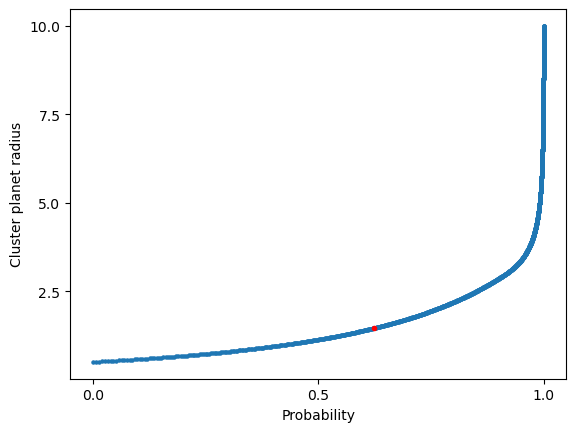

In [10]:
# CDF for radii
inc = 2000
x = np.linspace(r_p_min, r_p_max, inc)
y = np.zeros((inc, 2))
rpc1 = lambda x: x ** alpha_r1
rpc2 = lambda x: 3 ** 3.8 * x ** alpha_r2
for i in range(len(x)):
    if x[i] <= r_p_break:
        y[i] = [x[i], spi.quad(rpc1, r_p_min, x[i])[0]]
    else:
        y[i] = [x[i], spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, x[i])[0]]
normalization = spi.quad(rpc1, r_p_min, r_p_break)[0] + spi.quad(rpc2, r_p_break, r_p_max)[0]
plt.scatter(y[:,1]/normalization, y[:,0], s=5)
i = np.random.uniform(0, 1)
print(i)
id = (np.abs(y[:,1]/normalization - i)).argmin()
print(id)
print(y[id, 1]/normalization, y[id, 0])
plt.scatter(y[id, 1]/normalization, y[id, 0], s=9, c='r')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Probability')
plt.xticks(fontsize = 10)
plt.ylabel('Cluster planet radius')
plt.yticks(fontsize = 10)
plt.show()

142.7355785261754
0.3319476165263483
1411
0.470490163387796 142.7355785261754


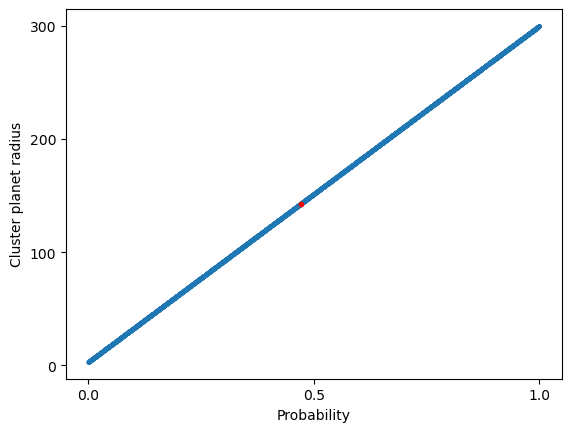

In [11]:
inc = 3000
x = np.linspace(p_min, p_max, inc)
y = np.zeros((inc, 2))
pc = lambda x: x ** alpha_p # broken power functions
for i in range(len(x)):
    y[i] = [x[i], spi.quad(pc, p_min, x[i])[0]] 
normalization = spi.quad(pc, p_min, p_max)[0] # sum of entire area under curve
i = np.random.uniform(0, 1)
id = (np.abs(y[:,1]/normalization - i)).argmin() # index of closest point
print( y[id, 0])
plt.scatter(y[:,1]/normalization, y[:,0], s=5)
i = np.random.uniform(0, 1)
print(i)
print(id)
print(y[id, 1]/normalization, y[id, 0])
plt.scatter(y[id, 1]/normalization, y[id, 0], s=9, c='r')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Probability')
plt.xticks(fontsize = 10)
plt.ylabel('Cluster planet radius')
plt.yticks(fontsize = 10)
plt.show()